In [176]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

In [177]:
def compute_bow(documents, max_features):
    """
    Computes the bag-of-words matrix for the given documents.

    Parameters:
    - documents: List of text documents.
    - max_features: Maximum number of features (vocabulary size).

    Returns:
    - bow_matrix: Sparse matrix of shape (n_samples, n_features).
    """
    # TODO: Implement me!
    vectorizer = CountVectorizer(max_features=max_features)
    bow_matrix = vectorizer.fit_transform(documents)
    return bow_matrix

In [178]:
def compute_tfidf(documents, max_features):
    """
    Computes the tfidf matrix for the given documents.

    Parameters:
    - documents: List of text documents.
    - max_features: Maximum number of features to use.

    Returns:
    - tfidf_matrix: Sparse matrix of shape (n_samples, n_features).
    """
    # TODO: Implement me!
    vectorizer = TfidfVectorizer(max_features=max_features)
    tfidf_matrix = vectorizer.fit_transform(documents)
    feature_names = vectorizer.get_feature_names_out()  # Extract feature names
    return tfidf_matrix, feature_names

In [179]:
def apply_lsa(tfidf_matrix, n_components):
    """
    Applies LSA (using TruncatedSVD) to the tfidf matrix.

    Parameters:
    - tfidf_matrix: Sparse matrix from tfidf vectorization.
    - n_components: Number of components to keep.

    Returns:
    - lsa_matrix: Dense matrix with reduced dimensions.
    """
    # TODO: Implement me!
    vectorizer = TruncatedSVD(n_components=n_components)
    lsa_matrix = vectorizer.fit_transform(tfidf_matrix)
    return lsa_matrix

In [180]:
def create_documents(df):
  documents = df['review'].tolist()
  return documents

In [181]:
def create_labels(df):
  labels = df['voted_up'].tolist()
  return labels

In [182]:
max_features = 1000

In [183]:
df = pd.read_csv('cleaned_data.csv')
documents = create_documents(df)
labels = create_labels(df)
bow_matrix = compute_bow(documents, 1000)
print("Bag of words matrix:")
print(bow_matrix)

tfidf_matrix, feature_names = compute_tfidf(documents, 1000)
print("TF-IDF matrix:")
print(tfidf_matrix)

lsa_matrix = apply_lsa(tfidf_matrix, 100)
print("LSA matrix:")
print(lsa_matrix)

Bag of words matrix:
  (0, 245)	1
  (0, 992)	1
  (0, 499)	1
  (0, 828)	1
  (0, 576)	1
  (0, 62)	2
  (0, 475)	1
  (0, 197)	1
  (0, 602)	1
  (0, 375)	1
  (0, 156)	1
  (0, 878)	1
  (0, 354)	1
  (0, 452)	1
  (0, 581)	1
  (0, 22)	1
  (0, 334)	1
  (0, 257)	1
  (0, 886)	1
  (0, 93)	1
  (1, 477)	1
  (1, 149)	1
  (1, 983)	1
  (1, 740)	1
  (1, 971)	1
  :	:
  (315, 905)	1
  (315, 614)	1
  (315, 796)	1
  (315, 675)	1
  (315, 185)	1
  (315, 766)	1
  (315, 887)	1
  (315, 323)	1
  (315, 800)	1
  (315, 883)	2
  (315, 853)	1
  (315, 41)	2
  (315, 457)	1
  (315, 343)	1
  (315, 526)	1
  (315, 370)	3
  (316, 992)	2
  (316, 375)	1
  (316, 833)	1
  (316, 351)	2
  (316, 969)	1
  (316, 507)	2
  (316, 400)	2
  (316, 347)	1
  (316, 376)	3
TF-IDF matrix:
  (0, 93)	0.2854102504808864
  (0, 886)	0.3181035953246477
  (0, 257)	0.2793103047645942
  (0, 334)	0.29215342762600116
  (0, 22)	0.18240463324517878
  (0, 581)	0.2854102504808864
  (0, 452)	0.12224323955679443
  (0, 354)	0.11515101057717371
  (0, 878)	0.1337123

In [184]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB



from xgboost import XGBClassifier



In [185]:
def evaluate_knn(features, labels, n_neighbors=5, test_size=0.2):
    """
    Splits the dataset, trains a kNN classifier, and evaluates performance.

    Parameters:
    - features: Feature matrix (can be tfidf or LSA-transformed).
    - labels: Ground truth labels.
    - n_neighbors: Number of neighbors for kNN.
    - test_size: Fraction of data to use for testing.

    Returns:
    - accuracy: Accuracy score on the test set.
    """
    trainX, testX, trainY, testY = train_test_split(features, labels, test_size=test_size)

    knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights='distance')
    knn.fit(trainX, trainY)

    predict = knn.predict(testX)
    accuracy = accuracy_score(testY, predict)
    print("Accuracy:", accuracy)
    print(classification_report(testY, predict))

    return accuracy, knn  # we return the trained model

In [186]:
def evaluate_decision_tree(X, y, test_size=0.2, max_depth=70):
    """
    Splits the dataset, trains a Decision Tree classifier,
    and evaluates performance.

    Parameters:
    - X: Feature matrix.
    - y: Ground truth labels.
    - test_size: Fraction of data to use for testing.
    - max_depth: Maximum depth of the decision tree.


    Returns:
    - accuracy: Accuracy score on the test set.
    - dt_model: The trained Decision Tree model.
    """
    # 1. Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # 2. Instantiate Model 
    dt_model = DecisionTreeClassifier(
        max_depth=max_depth,
        criterion='gini', 
        min_samples_split=2, 
        min_samples_leaf=1
    )

    # 3. Train
    dt_model.fit(X_train, y_train)

    # 4. Predict
    y_pred = dt_model.predict(X_test)

    # 5. Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Decision Tree (max_depth={max_depth}) Accuracy:", accuracy)
    print("Classification Report:\n", classification_report(y_test, y_pred))

    return accuracy, dt_model

In [187]:
def evaluate_naive_bayes(X, y, test_size=0.2):
    """
    Splits the dataset, trains a Naive Bayes classifier (MultinomialNB),
    and evaluates performance.

    Parameters:
    - X: Feature matrix (may not allow LSA features because negative values).
    - y: Ground truth labels.
    - test_size: Fraction of data to use for testing.

    Returns:
    - accuracy: Accuracy score on the test set.
    - nb_model: The trained Naive Bayes model.
    """
    # 1. Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # 2. Instantiate Model
    nb_model = MultinomialNB()
    # nb_model = GaussianNB()        # uncomment for lsa tfidf

    # 3. Train
    nb_model.fit(X_train, y_train)

    # 4. Predict
    y_pred = nb_model.predict(X_test)

    # 5. Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    print("Naive Bayes Accuracy:", accuracy)
    print("Classification Report:\n", classification_report(y_test, y_pred))

    return accuracy, nb_model

In [188]:
def evaluate_xgboost(X, y, test_size=0.2, n_estimators=300, max_depth=6, learning_rate=0.1, subsample=0.8):
    """
    Splits the dataset, trains an XGBoost classifier,
    and evaluates performance.

    Parameters:
    - X: Feature matrix.
    - y: Ground truth labels.
    - test_size: Fraction of data to use for testing.
    - n_estimators: Number of boosting rounds.
    - max_depth: Maximum depth of each tree.
    - learning_rate: Reduce overfitting.
    
    Returns:
    - accuracy: Accuracy score on the test set.
    - xgb_model: The trained XGBoost model.
    """
    # 1. Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # 2. Instantiate XGB model
    xgb_model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
    )

    # 3. Train
    xgb_model.fit(X_train, y_train)

    # 4. Predict
    y_pred = xgb_model.predict(X_test)

    # 5. Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    print(f"XGBoost (n_estimators={n_estimators}, max_depth={max_depth}, "
          f"learning_rate={learning_rate}) Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))

    return accuracy, xgb_model


In [189]:
# Run everything

y = create_labels(df)

bow_matrix = compute_bow(documents, max_features)
X_tfidf, feature_names = compute_tfidf(documents, max_features)
X_lsa = apply_lsa(X_tfidf, 100)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(bow_matrix, labels, test_size=0.2, random_state=42)

# accuracy, model = evaluate_knn(X_train, y_train, n_neighbors=5)

# acc_dt, model_dt = evaluate_decision_tree(X_tfidf, y, max_depth=70)

acc_nb, model_nb = evaluate_naive_bayes(X_tfidf, y)

# acc_xgb, model_xgb = evaluate_xgboost(X_tfidf, y)

Naive Bayes Accuracy: 0.875
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.88      1.00      0.93        56

    accuracy                           0.88        64
   macro avg       0.44      0.50      0.47        64
weighted avg       0.77      0.88      0.82        64



c:\Users\0979h\OneDrive\Desktop\CS506\CS506\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\0979h\OneDrive\Desktop\CS506\CS506\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\0979h\OneDrive\Desktop\CS506\CS506\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

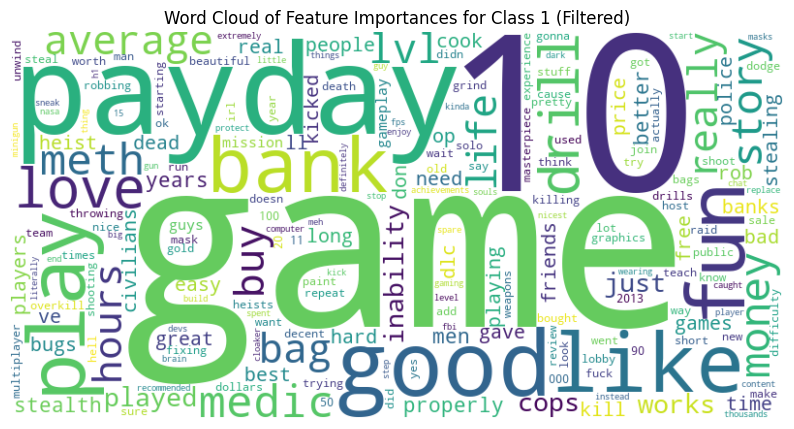

In [ ]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Get the log probabilities of features for each class
# Assuming model_nb is a trained MultinomialNB or similar Naive Bayes model
class_log_probs = model_nb.feature_log_prob_

# Focus on one class (e.g., class 1)
class_index = 1  # Change to 0 or 1 depending on the class you want to visualize
feature_importances = np.exp(class_log_probs[class_index])  # Convert log probabilities to probabilities

# Create a dictionary mapping words to their importance
word_importance = {feature_names[i]: feature_importances[i] for i in range(len(feature_names))}

# Filter out stop words
filtered_word_importance = {
    word: importance
    for word, importance in word_importance.items()
    if word not in ENGLISH_STOP_WORDS
}

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(filtered_word_importance)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f'Word Cloud of Feature Importances for Class {class_index} (Filtered)')
plt.show()

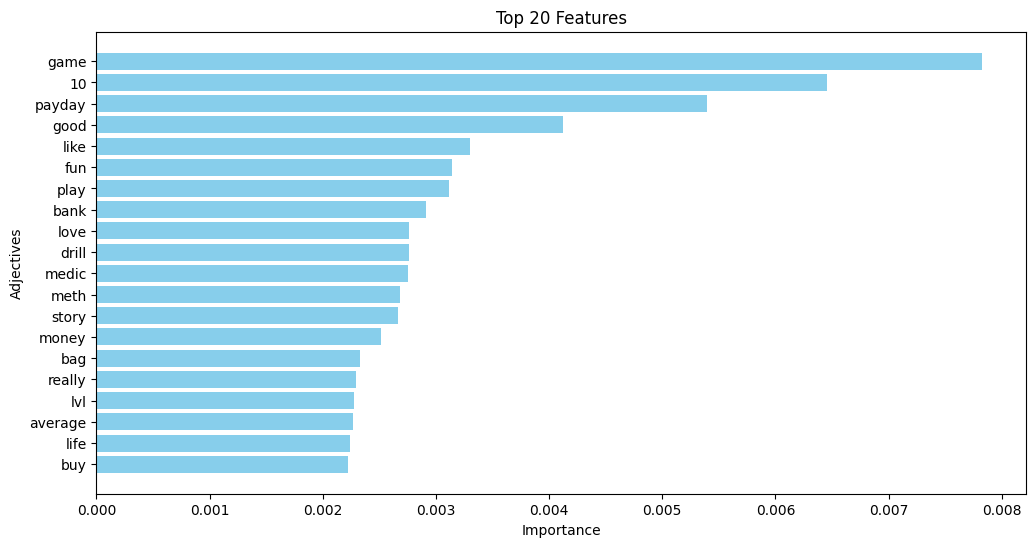

In [ ]:


# Convert the adjective importance dictionary to a DataFrame
adjective_df = pd.DataFrame(list(filtered_word_importance.items()), columns=['Word', 'Importance'])

# Sort by importance and select the top N features
top_n = 20
top_adjectives = adjective_df.sort_values(by='Importance', ascending=False).head(top_n)

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.barh(top_adjectives['Word'], top_adjectives['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.xlabel('Importance')
plt.ylabel('Adjectives')
plt.title(f'Top {top_n} Features')
plt.show()

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\0979h\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\0979h\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\0979h\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     C:\Users\0979h\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\0979h\AppData\Roaming\nltk_data...
[

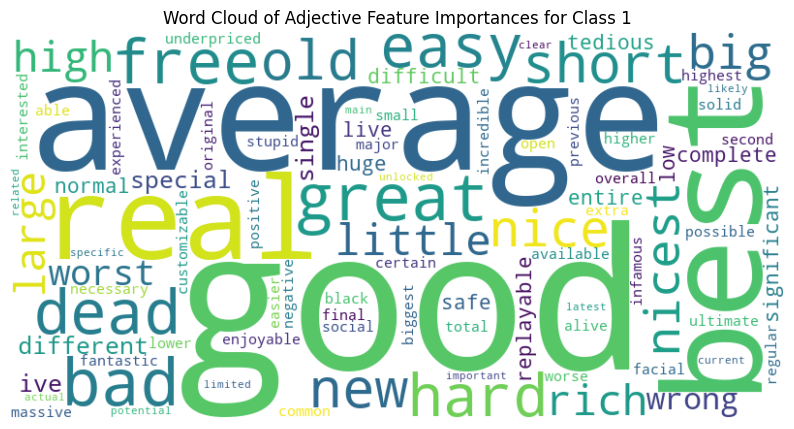

In [ ]:

import nltk
from nltk import pos_tag
from nltk.corpus import wordnet

# Download NLTK resources if not already downloaded
nltk.download('all')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Get the log probabilities of features for each class
# Assuming model_nb is a trained MultinomialNB or similar Naive Bayes model
class_log_probs = model_nb.feature_log_prob_

# Focus on one class (e.g., class 1)
class_index = 1  # Change to 0 or 1 depending on the class you want to visualize
feature_importances = np.exp(class_log_probs[class_index])  # Convert log probabilities to probabilities

# Create a dictionary mapping words to their importance
word_importance = {feature_names[i]: feature_importances[i] for i in range(len(feature_names))}

# Filter out stop words
filtered_word_importance = {
    word: importance
    for word, importance in word_importance.items()
    if word not in ENGLISH_STOP_WORDS
}

# Filter to include only adjectives
def is_adjective(word):
    pos = pos_tag([word])[0][1]  # Get the part of speech tag
    return pos.startswith('JJ')  # Adjectives in NLTK are tagged as 'JJ', 'JJR', or 'JJS'

adjective_word_importance = {
    word: importance
    for word, importance in filtered_word_importance.items()
    if is_adjective(word)
}

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(adjective_word_importance)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f'Word Cloud of Adjective Feature Importances for Class {class_index}')
plt.show()

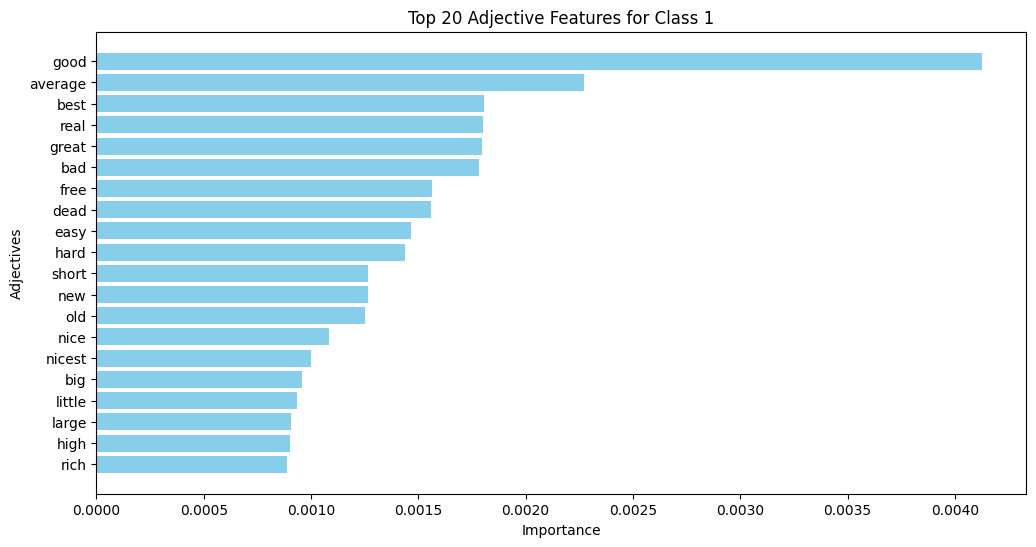

In [ ]:


# Convert the adjective importance dictionary to a DataFrame
adjective_df = pd.DataFrame(list(adjective_word_importance.items()), columns=['Word', 'Importance'])

# Sort by importance and select the top N features
top_n = 20
top_adjectives = adjective_df.sort_values(by='Importance', ascending=False).head(top_n)

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.barh(top_adjectives['Word'], top_adjectives['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.xlabel('Importance')
plt.ylabel('Adjectives')
plt.title(f'Top {top_n} Adjective Features for Class {class_index}')
plt.show()

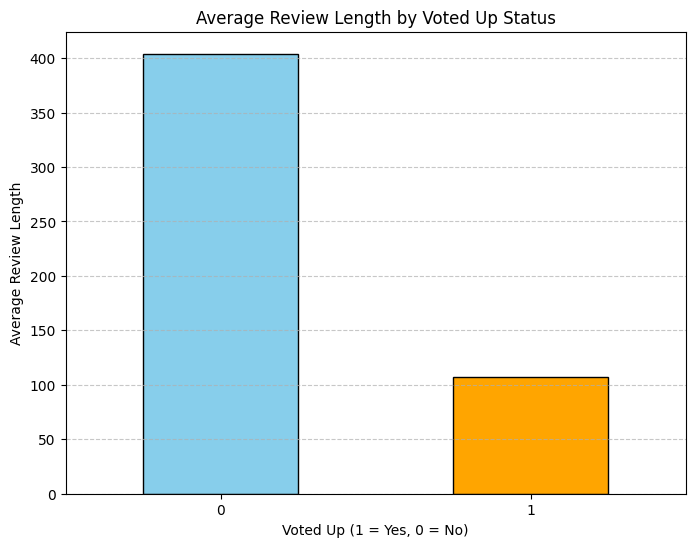

In [ ]:

# Load the CSV file
file_path = "cleaned_data.csv"  # Update this with the correct path if needed
df = pd.read_csv(file_path)

# Calculate the length of each review
df['review_length'] = df['review'].astype(str).apply(len)

# Group by 'voted_up' and calculate the average review length
avg_review_length = df.groupby('voted_up')['review_length'].median()


# Load the CSV file
file_path = "cleaned_data.csv"  # Update this with the correct path if needed
df = pd.read_csv(file_path)

# Calculate the length of each review
df['review_length'] = df['review'].astype(str).apply(len)

# Group by 'voted_up' and calculate the average review length
avg_review_length = df.groupby('voted_up')['review_length'].median()


# Plot the bar chart
plt.figure(figsize=(8, 6))
avg_review_length.plot(kind='bar', color=['skyblue', 'orange'], edgecolor='black')
plt.title('Average Review Length by Voted Up Status')
plt.xlabel('Voted Up (1 = Yes, 0 = No)')
plt.ylabel('Average Review Length')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

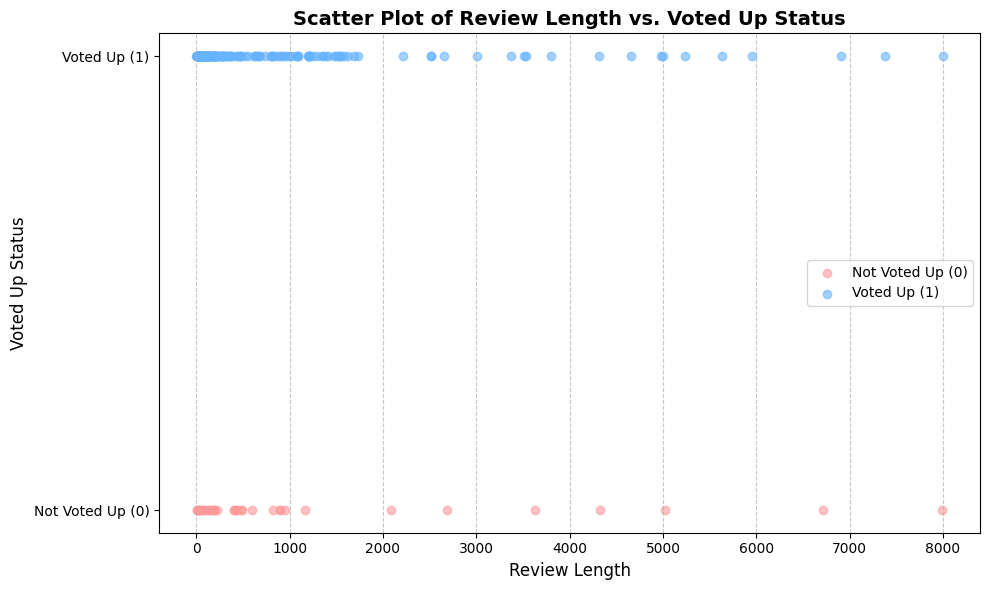

In [ ]:


# Load the CSV file
file_path = "cleaned_data.csv"  # Update this with the correct path if needed
df = pd.read_csv(file_path)

# Calculate the length of each review
df['review_length'] = df['review'].astype(str).apply(len)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(
    df[df['voted_up'] == 0]['review_length'],  # Review lengths for 'Not Voted Up'
    [0] * len(df[df['voted_up'] == 0]),       # Corresponding y-values (voted_up = 0)
    color='#FF9999', alpha=0.6, label='Not Voted Up (0)'
)
plt.scatter(
    df[df['voted_up'] == 1]['review_length'],  # Review lengths for 'Voted Up'
    [1] * len(df[df['voted_up'] == 1]),       # Corresponding y-values (voted_up = 1)
    color='#66B3FF', alpha=0.6, label='Voted Up (1)'
)

# Add titles and labels
plt.title('Scatter Plot of Review Length vs. Voted Up Status', fontsize=14, fontweight='bold')
plt.xlabel('Review Length', fontsize=12)
plt.ylabel('Voted Up Status', fontsize=12)
plt.yticks([0, 1], ['Not Voted Up (0)', 'Voted Up (1)'])  # Custom y-axis labels
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()